**Add Your Drive to the Folder**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports & Configurations

**Importing the Libraries**

In [1]:
# Deafault Imports
import os
import logging
import warnings as wr
import numpy as np
import random as rnd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras as tfk
from keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Our Imports
# import here your model script or functions

**Configurations**

In [2]:
# Random Configuration - All
SEED = 76998669
tf.compat.v1.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Local Functions**

In [14]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  fig, axes = plt.subplots(1,2, figsize=figsize)

  axes[0].plot(history['loss'], label='Training Loss', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', alpha=.8)
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

def plot_image(img, lbl):
  plt.figure(figsize=(10,10))
  plt.imshow(np.clip(img, 0, 1))
  plt.title(f'{lbl}')
  plt.show()
  print(img)

In [4]:
# Model Function
def apple_elixir_model(input_shape, output_shape, seed=SEED):

  tf.random.set_seed(seed)

  # Build the neural network layer by layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv00')(input_layer)
  x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv01')(x)
  x = tfkl.MaxPooling2D(name='mp0')(x)

  x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv10')(x)
  x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv11')(x)
  x = tfkl.MaxPooling2D(name='mp1')(x)

  x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv20')(x)
  x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv21')(x)
  x = tfkl.MaxPooling2D(name='mp2')(x)

  x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv30')(x)
  x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv31')(x)
  x = tfkl.GlobalAveragePooling2D(name='gap')(x)

  x = tfkl.Dense(units = 30, activation='relu')(x)
  x = tfkl.Dense(units = 20, activation='relu')(x)

  output_layer = tfkl.Dense(units=output_shape ,activation='softmax', name='Output')(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Convnet')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(weight_decay=5e-4), metrics=['accuracy'])

  return model

### Load and process the dataset

**Load the Dataset**

In [6]:
# Load the Dataset Files from Giovanni's Server
# !rm public_data.npz
!wget https://apps.barbiero.dev/static/public_data.npz

# !rm public_data_clean.npz
!wget https://apps.barbiero.dev/static/public_data_clean.npz

--2023-11-05 19:34:12--  https://apps.barbiero.dev/static/public_data.npz
Resolving apps.barbiero.dev (apps.barbiero.dev)... 104.21.8.111, 172.67.157.85, 2606:4700:3036::6815:86f, ...
Connecting to apps.barbiero.dev (apps.barbiero.dev)|104.21.8.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 575089497 (548M) [application/octet-stream]
Saving to: ‘public_data.npz’

public_data.npz     100%[===================>] 548.45M  19.2MB/s    in 30s     

2023-11-05 19:34:42 (18.5 MB/s) - ‘public_data.npz’ saved [575089497/575089497]

--2023-11-05 19:34:43--  https://apps.barbiero.dev/static/public_data_clean.npz
Resolving apps.barbiero.dev (apps.barbiero.dev)... 104.21.8.111, 172.67.157.85, 2606:4700:3036::6815:86f, ...
Connecting to apps.barbiero.dev (apps.barbiero.dev)|104.21.8.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536546306 (512M) [application/octet-stream]
Saving to: ‘public_data_clean.npz’

public_data_clean.n 100%[=======

**Store the Data**

In [8]:
# Initializate
dataset = np.load('public_data_clean.npz', allow_pickle=True)

# Split into Images and Labels + Normalize the Image Data Set
KEYS = list(dataset.keys())
IMG = np.array(dataset[KEYS[0]])/255
LBL = np.array(dataset[KEYS[1]])

LBL = list(map(lambda x: 0 if x == "healthy" else 1, LBL))
LBL = tf.keras.utils.to_categorical(LBL)                                          # Enable for MultiClass Problem

# Split the Data Set into Training XT YT, Validation XV YV, Test XTE YTE
Xtrv, XTE, Ytrv, YTE = train_test_split(IMG, LBL, test_size=500, random_state=SEED, stratify=np.argmax(LBL, axis=1))
XT, XV, YT, YV = train_test_split(Xtrv, Ytrv, test_size=500, random_state=SEED, stratify=np.argmax(Ytrv, axis=1))

print('Training Set Shape: ', XT.shape, YT.shape)
print('Validation Set Shape: ', XV.shape, YV.shape)
print('Test Set Shape: ', XTE.shape, YTE.shape)
print()

# Get the Shape of IN OUT
input_shape = XT.shape[1:]
output_shape = YT.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Training Set Shape:  (3850, 96, 96, 3) (3850, 2)
Validation Set Shape:  (500, 96, 96, 3) (500, 2)
Test Set Shape:  (500, 96, 96, 3) (500, 2)

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



### Training

**SetUp and Train**

Model: "Convnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv00 (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv01 (Conv2D)             (None, 96, 96, 32)        9248      
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv10 (Conv2D)             (None, 48, 48, 64)        18496     
                                                                 
 conv11 (Conv2D)             (None, 48, 48, 64)        36928     
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0   

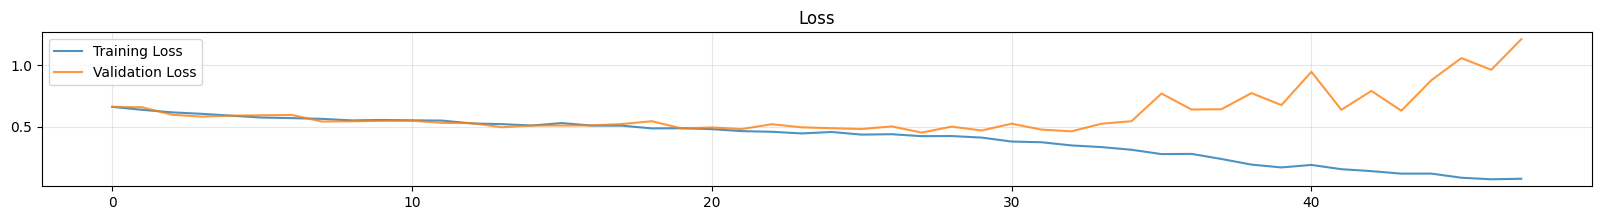

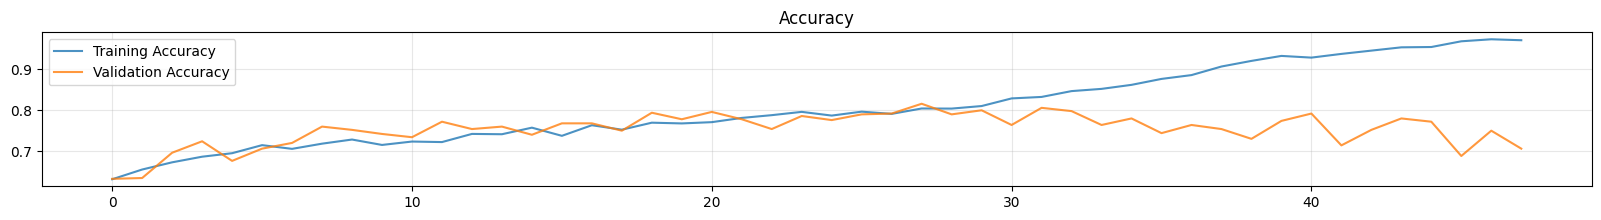

<Figure size 640x480 with 0 Axes>

In [ ]:
BTC = 32
EPO = 500
NAME_PLOT = "test_plot"
NAME_MODEL = "test_model"

model = apple_elixir_model(input_shape=input_shape, output_shape=output_shape)
model.summary()

history = model.fit(
  x = XT,                                                                         # We need to apply the preprocessing thought for the MobileNetV2 network
  y = YT,
  batch_size = BTC,
  epochs = EPO,
  validation_data = (XV, YV),                                               # We need to apply the preprocessing thought for the MobileNetV2 network
  callbacks = [
    tfk.callbacks.EarlyStopping(
      monitor='val_accuracy',
      mode='max',
      patience=20,
      restore_best_weights=True
    )
  ]
).history

plot_losses(history=history, figsize=(20,2), name_jpg=NAME_PLOT)
model.save(NAME_MODEL)
del model

### Evaluate the Model

In [ ]:
# Evaluate a Different Model From the one Just Trained
NAME_MODEL = ""

**Load the Model**

In [ ]:
model = tfk.models.load_model(NAME_MODEL)
model.summary()
print()

Model: "Convnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv00 (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv01 (Conv2D)             (None, 96, 96, 32)        9248      
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv10 (Conv2D)             (None, 48, 48, 64)        18496     
                                                                 
 conv11 (Conv2D)             (None, 48, 48, 64)        36928     
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0   

**Evaluate**

In [ ]:
# Training Comparison
train_predictions = model.predict(XT, verbose=0)
train_predictions = np.argmax(train_predictions, axis=-1)
train_gt = np.argmax(YT, axis=-1)
train_accuracy = accuracy_score(train_gt, train_predictions)
print(f'Accuracy Score over the Train Set: {round(train_accuracy, 4)}')
print()

# Validation Comparison
val_predictions = model.predict(XV, verbose=0)
val_predictions = np.argmax(val_predictions, axis=-1)
val_gt = np.argmax(YV, axis=-1)
val_accuracy = accuracy_score(val_gt, val_predictions)
print(f'Accuracy Score over the Validation Set: {round(val_accuracy, 4)}')
print()

# Test
test_predictions = model.predict(XT, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(YT, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy Score over the Train Set: 0.8374

Accuracy Score over the Validation Set: 0.816

Accuracy Score over the Test Set: 0.8374



### Extra

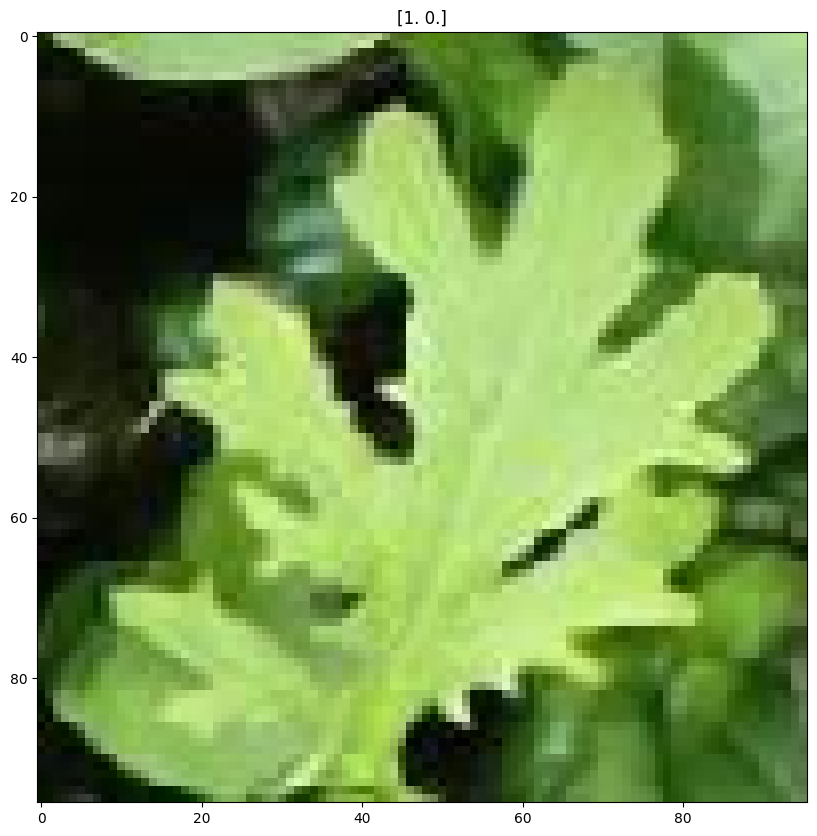

[[[0.07843138 0.14901961 0.        ]
  [0.17254902 0.24313726 0.08627451]
  [0.5921569  0.6784314  0.49803922]
  ...
  [0.69411767 0.8627451  0.58431375]
  [0.7058824  0.8784314  0.58431375]
  [0.70980394 0.88235295 0.5803922 ]]

 [[0.07058824 0.13725491 0.00392157]
  [0.04705882 0.11372549 0.        ]
  [0.33333334 0.41568628 0.25490198]
  ...
  [0.69411767 0.8627451  0.58431375]
  [0.7019608  0.8745098  0.5803922 ]
  [0.7019608  0.8745098  0.57254905]]

 [[0.04705882 0.09019608 0.02352941]
  [0.03529412 0.08627451 0.00784314]
  [0.00392157 0.06666667 0.        ]
  ...
  [0.67058825 0.8352941  0.5764706 ]
  [0.6666667  0.8352941  0.5568628 ]
  [0.6666667  0.8352941  0.5529412 ]]

 ...

 [[0.01176471 0.05098039 0.00784314]
  [0.02352941 0.0627451  0.01960784]
  [0.04313726 0.07058824 0.03921569]
  ...
  [0.39607844 0.54509807 0.32156864]
  [0.3254902  0.4509804  0.25882354]
  [0.31764707 0.44313726 0.2509804 ]]

 [[0.02352941 0.06666667 0.        ]
  [0.03137255 0.07450981 0.00784314]


In [15]:
plot_image(IMG[0], LBL[0])